In [4]:
import torch
import torch.nn as nn
import numpy as np
from torchvision import models
from sklearn.metrics import classification_report

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 8
print("Device:", device, "| num_classes:", num_classes)

Device: cpu | num_classes: 8


In [5]:
train_data = torch.load("isic_train_xy.pt")
test_data  = torch.load("isic_test_xy.pt")

train_X, train_y = train_data["X"], train_data["y"]
test_X,  test_y  = test_data["X"],  test_data["y"]

# Dataloader

In [6]:
from torch.utils.data import TensorDataset, DataLoader

BATCH_SIZE = 256
NUM_WORKERS = 2  # set 0 if Colab errors

train_ds = TensorDataset(train_X, train_y)
test_ds  = TensorDataset(test_X,  test_y)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)

# sanity
x, y = next(iter(train_loader))
print("batch x:", x.shape, "batch y:", y.shape)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


batch x: torch.Size([256, 3, 224, 224]) batch y: torch.Size([256])


#Helper Functions

In [7]:
def train_one_epoch(model, loader):
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        correct += (logits.argmax(1) == y).sum().item()
        total += y.size(0)

    return total_loss / total, correct / total


@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    all_preds, all_true = [], []

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)

        total_loss += loss.item() * x.size(0)
        preds = logits.argmax(1)

        correct += (preds == y).sum().item()
        total += y.size(0)

        all_preds.append(preds.cpu().numpy())
        all_true.append(y.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_true  = np.concatenate(all_true)
    return total_loss / total, correct / total, all_true, all_preds


# Resnet

In [52]:
from torchvision import models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = 9

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Replace final fully connected layer
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)
for param in model.parameters():
    param.requires_grad = False
model.fc.requires_grad = True

model = model.to(device)

print(model.fc)


Linear(in_features=512, out_features=9, bias=True)


In [41]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", patience=2, factor=0.5)

In [51]:
EPOCHS = 10
best_acc = 0.0

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader)
    va_loss, va_acc, _, _ = evaluate(model, test_loader)

    print(
        f"Epoch {epoch:02d} | "
        f"train loss {tr_loss:.4f} acc {tr_acc:.4f} | "
        f"test loss {va_loss:.4f} acc {va_acc:.4f}"
    )

    if va_acc > best_acc:
        best_acc = va_acc
        torch.save(model.state_dict(), "best_model.pt")
        print(f"nSaved new best model (test acc = {best_acc:.4f})")

AttributeError: 'collections.OrderedDict' object has no attribute 'train'

# Efficient Net B0

In [13]:
# EfficientNet-B0 (ImageNet pretrained)
num_classes = 8

model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

# Replace classifier head
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, num_classes)
for param in model.parameters():
    param.requires_grad = False
model.classifier[1].requires_grad = True
model = model.to(device)
print(model.classifier)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 195MB/s]

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=8, bias=True)
)


In [14]:
EPOCHS = 5
best_acc = 0.0

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader)
    va_loss, va_acc, y_true, y_pred = evaluate(model, test_loader)

    print(
        f"Epoch {epoch:02d} | "
        f"train loss {tr_loss:.4f} acc {tr_acc:.4f} | "
        f"test loss {va_loss:.4f} acc {va_acc:.4f}"
    )

    # simple early stopping: stop when accuracy stops improving
    if va_acc <= best_acc:
        print("Early stopping triggered")
        break

    best_acc = va_acc

KeyboardInterrupt: 

In [ ]:
classes = np.unique(y_true)
class_acc = []

for c in classes:
    idx = (y_true == c)
    acc_c = (y_pred[idx] == y_true[idx]).mean()
    class_acc.append(acc_c)

class_acc = np.array(class_acc)

if "id2label" in globals():
    class_names = [id2label[int(c)] for c in classes]
else:
    class_names = [f"Class {int(c)}" for c in classes]

order = np.argsort(class_acc)
class_acc = class_acc[order]
class_names = np.array(class_names)[order]

plt.figure(figsize=(10, 6))
bars = plt.barh(class_names, class_acc, color=plt.cm.Blues(class_acc))

plt.xlim(0, 1)
plt.xlabel("Accuracy")
plt.title("Accuracy per Class")
plt.grid(axis="x", linestyle="--", alpha=0.4)

for bar, acc in zip(bars, class_acc):
    plt.text(
        acc + 0.02,
        bar.get_y() + bar.get_height() / 2,
        f"{acc:.2f}",
        va="center",
        fontsize=10
    )

plt.tight_layout()
plt.show()

# MobileNetV2

In [ ]:
model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)

# Replace classifier head
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, num_classes)

model = model.to(device)
for param in model.parameters():
    param.requires_grad = False
model.classifier[1].requires_grad = True
print(model.classifier)

In [ ]:
EPOCHS = 5
best_acc = 0.0

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader)
    va_loss, va_acc, y_true, y_pred = evaluate(model, test_loader)

    print(
        f"Epoch {epoch:02d} | "
        f"train loss {tr_loss:.4f} acc {tr_acc:.4f} | "
        f"test loss {va_loss:.4f} acc {va_acc:.4f}"
    )

    # simple early stopping: stop when accuracy stops improving
    if va_acc <= best_acc:
        print("Early stopping triggered")
        break

    best_acc = va_acc

In [ ]:
classes = np.unique(y_true)
class_acc = []

for c in classes:
    idx = (y_true == c)
    acc_c = (y_pred[idx] == y_true[idx]).mean()
    class_acc.append(acc_c)

class_acc = np.array(class_acc)

if "id2label" in globals():
    class_names = [id2label[int(c)] for c in classes]
else:
    class_names = [f"Class {int(c)}" for c in classes]

order = np.argsort(class_acc)
class_acc = class_acc[order]
class_names = np.array(class_names)[order]

plt.figure(figsize=(10, 6))
bars = plt.barh(class_names, class_acc, color=plt.cm.Blues(class_acc))

plt.xlim(0, 1)
plt.xlabel("Accuracy")
plt.title("Accuracy per Class")
plt.grid(axis="x", linestyle="--", alpha=0.4)

for bar, acc in zip(bars, class_acc):
    plt.text(
        acc + 0.02,
        bar.get_y() + bar.get_height() / 2,
        f"{acc:.2f}",
        va="center",
        fontsize=10
    )

plt.tight_layout()
plt.show()

# Our Model

In [56]:
import torch.nn.functional as F

class DropPath(nn.Module):
    def __init__(self, drop_prob=0.0):
        super().__init__()
        self.drop_prob = float(drop_prob)

    def forward(self, x):
        if self.drop_prob == 0.0 or not self.training:
            return x
        keep_prob = 1.0 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # (B,1,1,1)
        rand = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
        mask = torch.floor(rand)
        return x / keep_prob * mask


class SEBlock(nn.Module):
    def __init__(self, ch, r=16):
        super().__init__()
        hidden = max(8, ch // r)
        self.fc1 = nn.Conv2d(ch, hidden, kernel_size=1, bias=True)
        self.fc2 = nn.Conv2d(hidden, ch, kernel_size=1, bias=True)

    def forward(self, x):
        s = F.adaptive_avg_pool2d(x, 1)
        s = F.relu(self.fc1(s), inplace=True)
        s = torch.sigmoid(self.fc2(s))
        return x * s

class PreActSEBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1, drop_path=0.0, se_r=16):
        super().__init__()
        self.bn1 = nn.BatchNorm2d(in_ch)
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, stride=stride, padding=1, bias=False)

        self.bn2 = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False)

        self.se = SEBlock(out_ch, r=se_r)
        self.dp = DropPath(drop_path)

        self.shortcut = nn.Identity()
        if stride != 1 or in_ch != out_ch:
            self.shortcut = nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=stride, bias=False)

    def forward(self, x):
        out = F.silu(self.bn1(x), inplace=True)
        shortcut = self.shortcut(out)  # pre-act shortcut

        out = self.conv1(out)
        out = self.conv2(F.silu(self.bn2(out), inplace=True))
        out = self.se(out)
        out = self.dp(out)
        return out + shortcut


class OurModel(nn.Module):
    def __init__(self, num_classes=8, width=48, layers=(2, 2, 2, 2), drop_path_rate=0.15):
        super().__init__()
        self.in_ch = width

        # medical images often do better with a smaller stem than 7x7
        self.stem = nn.Sequential(
            nn.Conv2d(3, width, kernel_size=3, stride=2, padding=1, bias=False),  # 224->112
            nn.BatchNorm2d(width),
            nn.SiLU(inplace=True),
            nn.Conv2d(width, width, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(width),
            nn.SiLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  # 112->56
        )

        total_blocks = sum(layers)
        dp_rates = torch.linspace(0, drop_path_rate, total_blocks).tolist()
        dp_i = 0

        self.layer1 = self._make_layer(width,   layers[0], stride=1, dp_rates=dp_rates, dp_i=dp_i); dp_i += layers[0]
        self.layer2 = self._make_layer(width*2, layers[1], stride=2, dp_rates=dp_rates, dp_i=dp_i); dp_i += layers[1]
        self.layer3 = self._make_layer(width*4, layers[2], stride=2, dp_rates=dp_rates, dp_i=dp_i); dp_i += layers[2]
        self.layer4 = self._make_layer(width*6, layers[3], stride=2, dp_rates=dp_rates, dp_i=dp_i); dp_i += layers[3]

        self.pool = nn.AdaptiveAvgPool2d(1)
        self.head = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(self.in_ch, num_classes)
        )

    def _make_layer(self, out_ch, blocks, stride, dp_rates, dp_i):
        layers = []
        for b in range(blocks):
            s = stride if b == 0 else 1
            layers.append(
                PreActSEBlock(
                    self.in_ch, out_ch, stride=s,
                    drop_path=dp_rates[dp_i + b],
                    se_r=16
                )
            )
            self.in_ch = out_ch
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.pool(x).flatten(1)
        return self.head(x)




In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = OurModel(num_classes=8).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", patience=2, factor=0.5)

In [58]:
model

OurModel(
  (stem): Sequential(
    (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
    (3): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): SiLU(inplace=True)
    (6): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): PreActSEBlock(
      (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (se): SEBlock(
        (fc1): Conv2d(48, 8, ker

In [59]:
EPOCHS = 50

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader)
    te_loss, te_acc, y_true, y_pred = evaluate(model, test_loader)

    scheduler.step(te_acc)

    print(
        f"Epoch {epoch:02d} | "
        f"train loss {tr_loss:.4f} acc {tr_acc:.4f} | "
        f"test loss {te_loss:.4f} acc {te_acc:.4f}")


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


KeyboardInterrupt: 

In [ ]:
state = torch.load("best_model.pt", map_location=device)
model.load_state_dict(state)
loss, acc, y_true, y_pred = evaluate(model, test_loader)

print(f"Accuracy: {acc:.4f}")

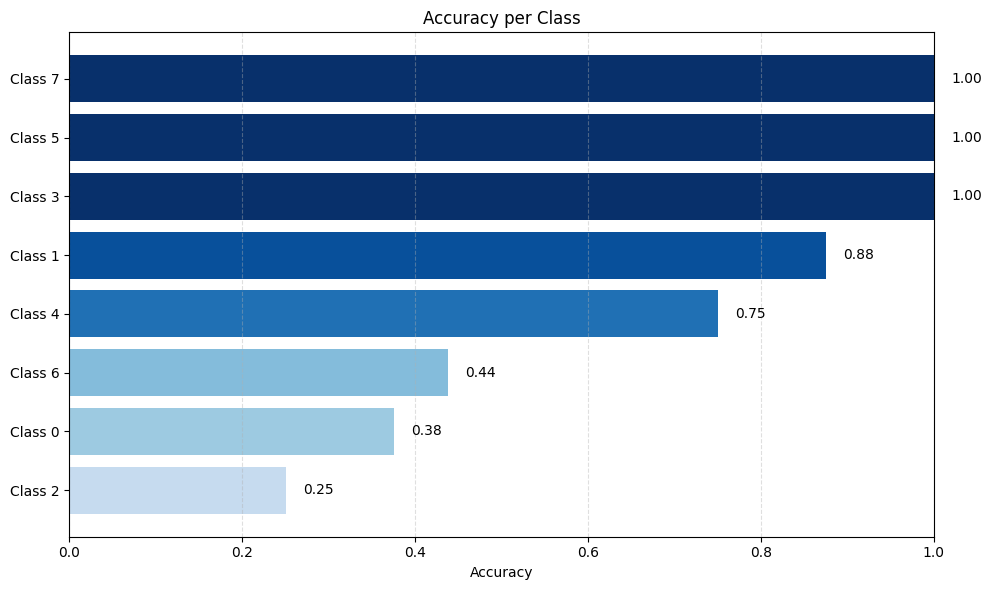

In [55]:
import matplotlib.pyplot as plt

classes = np.unique(y_true)
class_acc = []

for c in classes:
    idx = (y_true == c)
    acc_c = (y_pred[idx] == y_true[idx]).mean()
    class_acc.append(acc_c)

class_acc = np.array(class_acc)

if "id2label" in globals():
    class_names = [id2label[int(c)] for c in classes]
else:
    class_names = [f"Class {int(c)}" for c in classes]

order = np.argsort(class_acc)
class_acc = class_acc[order]
class_names = np.array(class_names)[order]

plt.figure(figsize=(10, 6))
bars = plt.barh(class_names, class_acc, color=plt.cm.Blues(class_acc))

plt.xlim(0, 1)
plt.xlabel("Accuracy")
plt.title("Accuracy per Class")
plt.grid(axis="x", linestyle="--", alpha=0.4)

for bar, acc in zip(bars, class_acc):
    plt.text(
        acc + 0.02,
        bar.get_y() + bar.get_height() / 2,
        f"{acc:.2f}",
        va="center",
        fontsize=10
    )

plt.tight_layout()
plt.show()